In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from models import Dataset
from recommendations import collaborative_filtering, content_based_filtering, popularity_based
from metrics import calc_precision_recall, calc_ndcg

Create a new Dataset instance \
Each Dataset contains Users that have up to 3 interests. \
For every interest every user has 1 or 2 products in their basket.

We have a total 1000 users and 20 products (sparse array shape: (1000, 20))

In [2]:
data = Dataset()

Get ground truth values for test split

In [3]:
y_true = data.users.loc[data.test.index, 'basket'].tolist()
y_true[0]

['Cars product 4', 'Sports product 4']

Run collaborative, content-based and popularity recommendations
* Collaborative filtering uses cosine similarity between the Users $\times$ Products sparse array
* Content-based uses jaccard similarity between the interest of two users
* Popularity based recommends all the products based on their cardinality in users' baskets

In [4]:
cb_y_pred = collaborative_filtering(data, th=0.5)
cbf_y_pred = content_based_filtering(data, th=0.2)
pop_y_pred = popularity_based(data)

Different cut-off values for average precision, average recall and ndcg are decided based on retrieved/predicted baskets

In [5]:
min_basket = min(len(min(i, key=len)) for i in (cb_y_pred, cbf_y_pred))
max_basket = data.n_products

items = [i for i in range(min_basket, max_basket+1)]
items

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [6]:
recommendations = ['Collaborative', 'Content-based', 'Popularity-based']
metrics = ['Precision', 'Recall', 'NDCG']
cols=pd.MultiIndex.from_product((recommendations,metrics))

results = pd.DataFrame(index=items, columns=cols)

for n_items in items:
    precision, recall = calc_precision_recall(y=y_true, pred=cb_y_pred, top_k=slice(None,n_items))
    ndcg = calc_ndcg(y_true=y_true, y_pred=cb_y_pred, top_k=slice(None,n_items))
    results.loc[n_items, 'Collaborative'] = [precision, recall, ndcg]

    precision, recall = calc_precision_recall(y_true, cbf_y_pred, top_k=slice(None,n_items))
    ndcg = calc_ndcg(y_true, cbf_y_pred, top_k=slice(None,n_items))
    results.loc[n_items, 'Content-based'] = [precision, recall, ndcg]

    precision, recall = calc_precision_recall(y_true, pop_y_pred, top_k=slice(None,n_items))
    ndcg = calc_ndcg(y_true, pop_y_pred, top_k=slice(None,n_items))
    results.loc[n_items, 'Popularity-based'] = [precision, recall, ndcg]

* x axis shows different number of cut-off values for our metrics
* y axis is the score

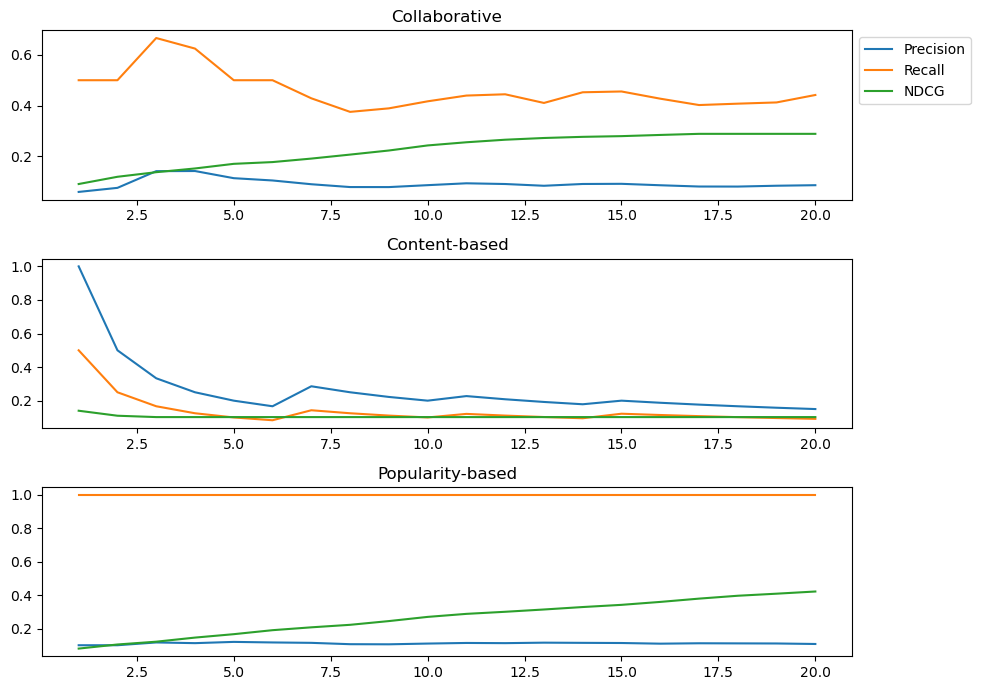

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 7))                       
results['Collaborative'].plot(ax=ax1)
ax1.set(title='Collaborative')
ax1.legend(bbox_to_anchor=[1,1])
results['Content-based'].plot(ax=ax2)
ax2.set(title='Content-based')
ax2.legend().remove()
results['Popularity-based'].plot(ax=ax3)
ax3.set(title='Popularity-based')
ax3.legend().remove()
plt.tight_layout();

### Machine Learning
Matrix Factorization using Singular Value Decomposition

The one hot encodings of the test set are set to zero. \
Our prediction is the the one hot encodings of the reconstructed Users $\times$ Products sparse matrix

In [8]:
from recommendations import svd

scores = lambda scores: pd.Series(index=['Precision', 'Recall', 'NDCG'], data=scores)

In [9]:
data = Dataset()
y_true = data.users.loc[data.test.index, 'basket'].tolist()

In [10]:
svd_y_pred = svd(data)

In [11]:
precision, recall = calc_precision_recall(y=y_true, pred=svd_y_pred)
ndcg = calc_ndcg(y_true=y_true, y_pred=svd_y_pred)

svd_scores = scores((precision, recall, ndcg))
svd_scores

Precision    0.001779
Recall       0.006667
NDCG         0.003288
dtype: float64

### Continuous Learning

We see that we have the lowest scores using SVD. \
This is due to large sparsity of the Users $\times$ Products matrix

We can solve this issue by continuing the user interactions and adding more products to their baskets.

We randomly add 1 in the sparse array

In [12]:
users, products = data.sparse.shape
1 - data.sparse.sum().sum() / (users * products)

0.90095

In [13]:
def change_sparsity(data, k):
    users, products = data.sparse.shape

    print (f'Sparsity before: {1 - data.sparse.sum().sum() / (users * products)}')

    while data.sparse.sum().sum() / (users * products) < k:
        sample = data.sparse.sample(1).sample(1, axis=1)
        data.sparse.loc[sample.index, sample.columns] = 1

    print (f'Sparsity after: {1 - data.sparse.sum().sum() / (users * products)}')

In [14]:
continuous = {1 - data.sparse.sum().sum() / (users * products): svd_scores}
continuous

{0.90095: Precision    0.001779
 Recall       0.006667
 NDCG         0.003288
 dtype: float64}

In [15]:
def get_scores(data, sparsity):
    change_sparsity(data, sparsity)
    svd_y_pred = svd(data)

    precision, recall = calc_precision_recall(y=y_true, pred=svd_y_pred)
    ndcg = calc_ndcg(y_true=y_true, y_pred=svd_y_pred)

    return scores((precision, recall, ndcg))

In [16]:
sparsity = {1-k: get_scores(data,k) for k in [0.15, 0.2, 0.3, 0.4, 0.5]}

Sparsity before: 0.90095
Sparsity after: 0.85
Sparsity before: 0.85
Sparsity after: 0.8
Sparsity before: 0.8
Sparsity after: 0.7
Sparsity before: 0.7
Sparsity after: 0.6
Sparsity before: 0.6
Sparsity after: 0.5


In [17]:
continuous.update(sparsity)

Scores for different sparsities up to 0.5

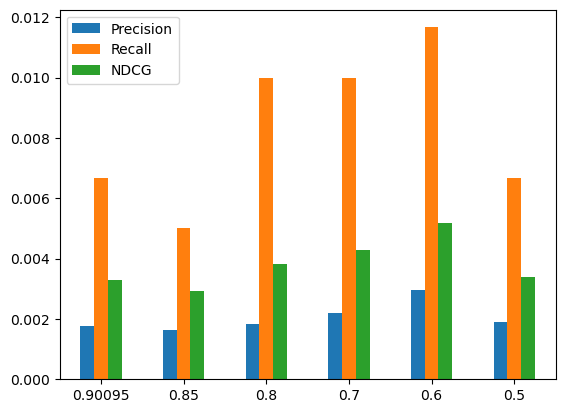

In [18]:
objs = continuous.values()
keys = continuous.keys()
ax = pd.concat(objs=objs, keys=keys, axis=1).T.plot(kind='bar')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0);

We can see that our scores slightly increase, but still this method remain the worse out of all.

This is due to the bad quality of the sparse array. \
Seems using a one-hot encoding representation is not very accuracate to reconstruct.